# Autoencoders in SciKeras

Autencoders are an approach to use nearual networks to distill data into it's most important features, thereby compressing the data. We will be following the [Keras tutorial](https://blog.keras.io/building-autoencoders-in-keras.html) on the topic, which goes much more in depth and breadth than we will here. You are highly encouraged to check out that tutorial if you want to learn about autoencoders in the general sense.

## Table of contents

* [1. Setup](#1.-Setup)
* [2. Data](#2.-Data)
* [3. Define Keras Model](#3.-Define-Keras-Model)
* [4. Training](#4.-Training)
* [5. Explore Results](#5.-Explore-Results)

## 1. Setup

In [1]:
try:
    import scikeras
except ImportError:
    !python -m pip install scikeras

Silence TensorFlow logging to keep output succinct.

In [2]:
import warnings
from tensorflow import get_logger
get_logger().setLevel('ERROR')
warnings.filterwarnings("ignore", message="Setting the random state for TF")

In [3]:
import numpy as np
from scikeras.wrappers import KerasClassifier, KerasRegressor
from tensorflow import keras

## 2. Data

We load the dataset from the Keras tutorial. The dataset consists of images of cats and dogs.

In [4]:
from tensorflow.keras.datasets import mnist
import numpy as np


(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

    8192/11490434 [..............................] - ETA: 0s

 4997120/11490434 [============>.................] - ETA: 0s

11493376/11490434 [==============================] - 0s 0us/step


(60000, 784)
(10000, 784)


## 3. Define Keras Model

We will be defining a very simple autencoder. We define _three_ model building methods:

1. One to build a full end-to-end autoencoder.
2. One to create a model that includes only the encoder portion.
3. One that creates a model that includes only the decoder portion.

The only variable we give our model is the encoding dimensions, which will be a hyperparemter of our final transformer.

In [5]:
from tensorflow import keras


def get_fit_model(encoding_dim: int) -> keras.Model:
    """Get an autoencoder.

    This autoencoder compresses a 28x28 image (784 pixels) down to a feature of length
    `encoding_dim`, and tries to reconstruct the input image from that vector.
    """
    input_img = keras.Input(shape=(784,), name="input")
    encoded = keras.layers.Dense(encoding_dim, activation='relu', name="encoded")(input_img)
    decoded = keras.layers.Dense(784, activation='sigmoid', name="output")(encoded)
    autoencoder_model = keras.Model(input_img, decoded)
    return autoencoder_model

def get_tf_model(fit_model: keras.Model) -> keras.Model:
    """Get an encoder model.

    We do this by extracting the encoding layer from the fitted autoencoder model.
    """
    return keras.Model(fit_model.get_layer("input").input, fit_model.get_layer("encoded").output)

def get_inverse_tf_model(fit_model: keras.Model, encoding_dim: int) -> keras.Model:
    """Get an deencoder model.

    We do this by extracting the deencoding layer from the fitted autoencoder model
    and adding a new Keras input layer.
    """
    encoded_input = keras.Input(shape=(encoding_dim,))
    output = fit_model.get_layer("output")(encoded_input)
    return keras.Model(encoded_input, output)

Next we create a class that that will enable the `transform` and `fit_transform` methods, as well as integrating all three of our models into a single estimator.

In [6]:
from sklearn.base import TransformerMixin, clone
from scikeras.wrappers import BaseWrapper


class KerasTransformer(BaseWrapper, TransformerMixin):
    """A class that enables transform and fit_transform.
    """

    def __init__(self, *args, tf_est: BaseWrapper = None, inv_tf_est: BaseWrapper = None, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.tf_est = tf_est
        self.inv_tf_est = inv_tf_est


    def fit(self, X, sample_weight=None):
        super().fit(X=X, y=X, sample_weight=sample_weight)
        self.tf_est_ = clone(self.tf_est)
        self.inv_tf_est_ = clone(self.inv_tf_est)
        self.tf_est_.set_params(fit_model=self.model_)
        self.inv_tf_est_.set_params(fit_model=self.model_, encoding_dim=self.encoding_dim)
        X = self.feature_encoder_.transform(X)
        self.tf_est_.initialize(X=X)
        X_tf = self.tf_est_.predict(X=X)
        self.inv_tf_est_.initialize(X_tf)
        return self

    def transform(self, X):
        X = self.feature_encoder_.transform(X)
        X_tf = self.tf_est_.predict(X)
        return X_tf
    
    def inverse_transform(self, X_tf):
        X = self.inv_tf_est_.predict(X_tf)
        X = self.feature_encoder_.inverse_transform(X)
        return X

Next, we wrap the Keras Model with Scikeras. Note that for our encoder/decoder estimators, we do not need to provide a loss function since no training will be done. We do however need to have the `fit_model` and `encoding_dim` so that these will be settable by `BaseWrapper.set_params`.

In [7]:
tf_est = BaseWrapper(model=get_tf_model, fit_model=None, verbose=0)
inv_tf_est = BaseWrapper(model=get_inverse_tf_model, fit_model=None, encoding_dim=None, verbose=0)
autoencoder = KerasTransformer(model=get_fit_model, tf_est=tf_est, inv_tf_est=inv_tf_est, loss="binary_crossentropy", encoding_dim=32, epochs=5)

## 4. Training

To train the model, we pass the input images as both the features and the target. This will train the layers to compress the data as accurately as possible between the encoder and decoder. Note that we only pass the `X` parameter, since we defined the mapping `y=X` in `KerasTransformer.fit` above.

In [8]:
_ = autoencoder.fit(X=x_train)

Epoch 1/5


   1/1875 [..............................] - ETA: 11:14 - loss: 0.6940

  27/1875 [..............................] - ETA: 3s - loss: 0.5486   

  55/1875 [..............................] - ETA: 3s - loss: 0.4665

  85/1875 [>.............................] - ETA: 3s - loss: 0.4217

 117/1875 [>.............................] - ETA: 3s - loss: 0.3924

 148/1875 [=>............................] - ETA: 3s - loss: 0.3724

 178/1875 [=>............................] - ETA: 2s - loss: 0.3576

 205/1875 [==>...........................] - ETA: 2s - loss: 0.3466

 235/1875 [==>...........................] - ETA: 2s - loss: 0.3362

 267/1875 [===>..........................] - ETA: 2s - loss: 0.3266

 296/1875 [===>..........................] - ETA: 2s - loss: 0.3190

 328/1875 [====>.........................] - ETA: 2s - loss: 0.3115

 354/1875 [====>.........................] - ETA: 2s - loss: 0.3060

 383/1875 [=====>........................] - ETA: 2s - loss: 0.3004

 405/1875 [=====>........................] - ETA: 2s - loss: 0.2964

 432/1875 [=====>........................] - ETA: 2s - loss: 0.2919

 449/1875 [======>.......................] - ETA: 2s - loss: 0.2892

 481/1875 [======>.......................] - ETA: 2s - loss: 0.2845

 511/1875 [=======>......................] - ETA: 2s - loss: 0.2804

 541/1875 [=======>......................] - ETA: 2s - loss: 0.2765

 570/1875 [========>.....................] - ETA: 2s - loss: 0.2731

 603/1875 [========>.....................] - ETA: 2s - loss: 0.2693

 633/1875 [=========>....................] - ETA: 2s - loss: 0.2661

 661/1875 [=========>....................] - ETA: 2s - loss: 0.2633

 690/1875 [==========>...................] - ETA: 2s - loss: 0.2605

 719/1875 [==========>...................] - ETA: 2s - loss: 0.2579

 749/1875 [==========>...................] - ETA: 1s - loss: 0.2553

 784/1875 [===========>..................] - ETA: 1s - loss: 0.2524

 819/1875 [============>.................] - ETA: 1s - loss: 0.2496

 850/1875 [============>.................] - ETA: 1s - loss: 0.2473

 883/1875 [=============>................] - ETA: 1s - loss: 0.2449

 916/1875 [=============>................] - ETA: 1s - loss: 0.2427

 947/1875 [==============>...............] - ETA: 1s - loss: 0.2407

 978/1875 [==============>...............] - ETA: 1s - loss: 0.2387

1008/1875 [===============>..............] - ETA: 1s - loss: 0.2369

1039/1875 [===============>..............] - ETA: 1s - loss: 0.2350

1068/1875 [================>.............] - ETA: 1s - loss: 0.2334

1102/1875 [================>.............] - ETA: 1s - loss: 0.2315

1133/1875 [=================>............] - ETA: 1s - loss: 0.2299

1163/1875 [=================>............] - ETA: 1s - loss: 0.2283

1188/1875 [==================>...........] - ETA: 1s - loss: 0.2271

1218/1875 [==================>...........] - ETA: 1s - loss: 0.2256

1246/1875 [==================>...........] - ETA: 1s - loss: 0.2243

1276/1875 [===================>..........] - ETA: 1s - loss: 0.2230

1304/1875 [===================>..........] - ETA: 0s - loss: 0.2217

1334/1875 [====================>.........] - ETA: 0s - loss: 0.2204

1363/1875 [====================>.........] - ETA: 0s - loss: 0.2192

1392/1875 [=====================>........] - ETA: 0s - loss: 0.2180

1419/1875 [=====================>........] - ETA: 0s - loss: 0.2169

1446/1875 [======================>.......] - ETA: 0s - loss: 0.2159

1472/1875 [======================>.......] - ETA: 0s - loss: 0.2149

1498/1875 [======================>.......] - ETA: 0s - loss: 0.2139

1526/1875 [=======================>......] - ETA: 0s - loss: 0.2129

1556/1875 [=======================>......] - ETA: 0s - loss: 0.2118

1587/1875 [========================>.....] - ETA: 0s - loss: 0.2107

1616/1875 [========================>.....] - ETA: 0s - loss: 0.2097

1647/1875 [=========================>....] - ETA: 0s - loss: 0.2087

1677/1875 [=========================>....] - ETA: 0s - loss: 0.2077

1709/1875 [==========================>...] - ETA: 0s - loss: 0.2067

1739/1875 [==========================>...] - ETA: 0s - loss: 0.2058

1769/1875 [===========================>..] - ETA: 0s - loss: 0.2048

1799/1875 [===========================>..] - ETA: 0s - loss: 0.2040

1825/1875 [============================>.] - ETA: 0s - loss: 0.2032

1852/1875 [============================>.] - ETA: 0s - loss: 0.2024

1875/1875 [==============================] - 4s 2ms/step - loss: 0.2017


Epoch 2/5
   1/1875 [..............................] - ETA: 3s - loss: 0.1136

  27/1875 [..............................] - ETA: 3s - loss: 0.1093

  52/1875 [..............................] - ETA: 3s - loss: 0.1094

  79/1875 [>.............................] - ETA: 3s - loss: 0.1092

 106/1875 [>.............................] - ETA: 3s - loss: 0.1092

 134/1875 [=>............................] - ETA: 3s - loss: 0.1091

 162/1875 [=>............................] - ETA: 3s - loss: 0.1090

 190/1875 [==>...........................] - ETA: 3s - loss: 0.1089

 216/1875 [==>...........................] - ETA: 3s - loss: 0.1089

 243/1875 [==>...........................] - ETA: 3s - loss: 0.1088

 271/1875 [===>..........................] - ETA: 3s - loss: 0.1087

 298/1875 [===>..........................] - ETA: 2s - loss: 0.1087

 326/1875 [====>.........................] - ETA: 2s - loss: 0.1086

 356/1875 [====>.........................] - ETA: 2s - loss: 0.1085

 385/1875 [=====>........................] - ETA: 2s - loss: 0.1084

 412/1875 [=====>........................] - ETA: 2s - loss: 0.1083

 440/1875 [======>.......................] - ETA: 2s - loss: 0.1082

 468/1875 [======>.......................] - ETA: 2s - loss: 0.1082

 497/1875 [======>.......................] - ETA: 2s - loss: 0.1081

 526/1875 [=======>......................] - ETA: 2s - loss: 0.1081

 557/1875 [=======>......................] - ETA: 2s - loss: 0.1080

 588/1875 [========>.....................] - ETA: 2s - loss: 0.1079

 619/1875 [========>.....................] - ETA: 2s - loss: 0.1079

 646/1875 [=========>....................] - ETA: 2s - loss: 0.1078

 673/1875 [=========>....................] - ETA: 2s - loss: 0.1077

 700/1875 [==========>...................] - ETA: 2s - loss: 0.1077

 726/1875 [==========>...................] - ETA: 2s - loss: 0.1076

 741/1875 [==========>...................] - ETA: 2s - loss: 0.1076

 759/1875 [===========>..................] - ETA: 2s - loss: 0.1076

 773/1875 [===========>..................] - ETA: 2s - loss: 0.1075

 800/1875 [===========>..................] - ETA: 2s - loss: 0.1075

 826/1875 [============>.................] - ETA: 2s - loss: 0.1074

 851/1875 [============>.................] - ETA: 1s - loss: 0.1074

 873/1875 [============>.................] - ETA: 1s - loss: 0.1073

 900/1875 [=============>................] - ETA: 1s - loss: 0.1073

 931/1875 [=============>................] - ETA: 1s - loss: 0.1072

 960/1875 [==============>...............] - ETA: 1s - loss: 0.1072

 989/1875 [==============>...............] - ETA: 1s - loss: 0.1071

1013/1875 [===============>..............] - ETA: 1s - loss: 0.1071

1043/1875 [===============>..............] - ETA: 1s - loss: 0.1070

1071/1875 [================>.............] - ETA: 1s - loss: 0.1070

1101/1875 [================>.............] - ETA: 1s - loss: 0.1069

1129/1875 [=================>............] - ETA: 1s - loss: 0.1069

1158/1875 [=================>............] - ETA: 1s - loss: 0.1068

1186/1875 [=================>............] - ETA: 1s - loss: 0.1068

1216/1875 [==================>...........] - ETA: 1s - loss: 0.1067

1246/1875 [==================>...........] - ETA: 1s - loss: 0.1066

1277/1875 [===================>..........] - ETA: 1s - loss: 0.1066

1303/1875 [===================>..........] - ETA: 1s - loss: 0.1065

1334/1875 [====================>.........] - ETA: 1s - loss: 0.1065

1364/1875 [====================>.........] - ETA: 0s - loss: 0.1064

1389/1875 [=====================>........] - ETA: 0s - loss: 0.1064

1419/1875 [=====================>........] - ETA: 0s - loss: 0.1063

1449/1875 [======================>.......] - ETA: 0s - loss: 0.1063

1479/1875 [======================>.......] - ETA: 0s - loss: 0.1062

1507/1875 [=======================>......] - ETA: 0s - loss: 0.1062

1536/1875 [=======================>......] - ETA: 0s - loss: 0.1061

1565/1875 [========================>.....] - ETA: 0s - loss: 0.1061

1592/1875 [========================>.....] - ETA: 0s - loss: 0.1060

1621/1875 [========================>.....] - ETA: 0s - loss: 0.1060

1651/1875 [=========================>....] - ETA: 0s - loss: 0.1059

1682/1875 [=========================>....] - ETA: 0s - loss: 0.1059

1712/1875 [==========================>...] - ETA: 0s - loss: 0.1058

1739/1875 [==========================>...] - ETA: 0s - loss: 0.1058

1769/1875 [===========================>..] - ETA: 0s - loss: 0.1057

1799/1875 [===========================>..] - ETA: 0s - loss: 0.1057

1826/1875 [============================>.] - ETA: 0s - loss: 0.1057

1850/1875 [============================>.] - ETA: 0s - loss: 0.1056

1873/1875 [============================>.] - ETA: 0s - loss: 0.1056

1875/1875 [==============================] - 3s 2ms/step - loss: 0.1056


Epoch 3/5
   1/1875 [..............................] - ETA: 3s - loss: 0.1053

  28/1875 [..............................] - ETA: 3s - loss: 0.0996

  51/1875 [..............................] - ETA: 3s - loss: 0.0989

  80/1875 [>.............................] - ETA: 3s - loss: 0.0986

 101/1875 [>.............................] - ETA: 3s - loss: 0.0985

 122/1875 [>.............................] - ETA: 3s - loss: 0.0984

 141/1875 [=>............................] - ETA: 3s - loss: 0.0984

 167/1875 [=>............................] - ETA: 3s - loss: 0.0984

 194/1875 [==>...........................] - ETA: 3s - loss: 0.0984

 221/1875 [==>...........................] - ETA: 3s - loss: 0.0984

 246/1875 [==>...........................] - ETA: 3s - loss: 0.0984

 276/1875 [===>..........................] - ETA: 3s - loss: 0.0983

 307/1875 [===>..........................] - ETA: 3s - loss: 0.0983

 338/1875 [====>.........................] - ETA: 3s - loss: 0.0983

 368/1875 [====>.........................] - ETA: 2s - loss: 0.0983

 400/1875 [=====>........................] - ETA: 2s - loss: 0.0983

 431/1875 [=====>........................] - ETA: 2s - loss: 0.0983

 459/1875 [======>.......................] - ETA: 2s - loss: 0.0983

 488/1875 [======>.......................] - ETA: 2s - loss: 0.0983

 517/1875 [=======>......................] - ETA: 2s - loss: 0.0982

 548/1875 [=======>......................] - ETA: 2s - loss: 0.0982

 573/1875 [========>.....................] - ETA: 2s - loss: 0.0982

 597/1875 [========>.....................] - ETA: 2s - loss: 0.0982

 622/1875 [========>.....................] - ETA: 2s - loss: 0.0982

 651/1875 [=========>....................] - ETA: 2s - loss: 0.0982

 680/1875 [=========>....................] - ETA: 2s - loss: 0.0981

 710/1875 [==========>...................] - ETA: 2s - loss: 0.0981

 740/1875 [==========>...................] - ETA: 2s - loss: 0.0981

 770/1875 [===========>..................] - ETA: 2s - loss: 0.0981

 797/1875 [===========>..................] - ETA: 2s - loss: 0.0981

 818/1875 [============>.................] - ETA: 1s - loss: 0.0981

 844/1875 [============>.................] - ETA: 1s - loss: 0.0981

 868/1875 [============>.................] - ETA: 1s - loss: 0.0981

 895/1875 [=============>................] - ETA: 1s - loss: 0.0980

 920/1875 [=============>................] - ETA: 1s - loss: 0.0980

 947/1875 [==============>...............] - ETA: 1s - loss: 0.0980

 974/1875 [==============>...............] - ETA: 1s - loss: 0.0980

1002/1875 [===============>..............] - ETA: 1s - loss: 0.0980

1030/1875 [===============>..............] - ETA: 1s - loss: 0.0980

1057/1875 [===============>..............] - ETA: 1s - loss: 0.0980

1082/1875 [================>.............] - ETA: 1s - loss: 0.0980

1109/1875 [================>.............] - ETA: 1s - loss: 0.0980

1135/1875 [=================>............] - ETA: 1s - loss: 0.0980

1163/1875 [=================>............] - ETA: 1s - loss: 0.0980

1191/1875 [==================>...........] - ETA: 1s - loss: 0.0979

1218/1875 [==================>...........] - ETA: 1s - loss: 0.0979

1246/1875 [==================>...........] - ETA: 1s - loss: 0.0979

1272/1875 [===================>..........] - ETA: 1s - loss: 0.0979

1301/1875 [===================>..........] - ETA: 1s - loss: 0.0979

1325/1875 [====================>.........] - ETA: 1s - loss: 0.0979

1355/1875 [====================>.........] - ETA: 0s - loss: 0.0979

1384/1875 [=====================>........] - ETA: 0s - loss: 0.0979

1413/1875 [=====================>........] - ETA: 0s - loss: 0.0979

1438/1875 [======================>.......] - ETA: 0s - loss: 0.0979

1466/1875 [======================>.......] - ETA: 0s - loss: 0.0979

1491/1875 [======================>.......] - ETA: 0s - loss: 0.0978

1518/1875 [=======================>......] - ETA: 0s - loss: 0.0978

1545/1875 [=======================>......] - ETA: 0s - loss: 0.0978

1573/1875 [========================>.....] - ETA: 0s - loss: 0.0978

1602/1875 [========================>.....] - ETA: 0s - loss: 0.0978

1631/1875 [=========================>....] - ETA: 0s - loss: 0.0978

1660/1875 [=========================>....] - ETA: 0s - loss: 0.0978

1689/1875 [==========================>...] - ETA: 0s - loss: 0.0978

1719/1875 [==========================>...] - ETA: 0s - loss: 0.0978

1748/1875 [==========================>...] - ETA: 0s - loss: 0.0978

1776/1875 [===========================>..] - ETA: 0s - loss: 0.0977

1804/1875 [===========================>..] - ETA: 0s - loss: 0.0977

1832/1875 [============================>.] - ETA: 0s - loss: 0.0977

1860/1875 [============================>.] - ETA: 0s - loss: 0.0977

1875/1875 [==============================] - 4s 2ms/step - loss: 0.0977


Epoch 4/5
   1/1875 [..............................] - ETA: 3s - loss: 0.0972

  29/1875 [..............................] - ETA: 3s - loss: 0.0950

  57/1875 [..............................] - ETA: 3s - loss: 0.0953

  85/1875 [>.............................] - ETA: 3s - loss: 0.0953

 112/1875 [>.............................] - ETA: 3s - loss: 0.0953

 139/1875 [=>............................] - ETA: 3s - loss: 0.0954

 164/1875 [=>............................] - ETA: 3s - loss: 0.0954

 192/1875 [==>...........................] - ETA: 3s - loss: 0.0954

 221/1875 [==>...........................] - ETA: 3s - loss: 0.0954

 250/1875 [===>..........................] - ETA: 2s - loss: 0.0955

 278/1875 [===>..........................] - ETA: 2s - loss: 0.0955

 303/1875 [===>..........................] - ETA: 2s - loss: 0.0955

 330/1875 [====>.........................] - ETA: 2s - loss: 0.0956

 360/1875 [====>.........................] - ETA: 2s - loss: 0.0956

 389/1875 [=====>........................] - ETA: 2s - loss: 0.0956

 419/1875 [=====>........................] - ETA: 2s - loss: 0.0956

 448/1875 [======>.......................] - ETA: 2s - loss: 0.0956

 478/1875 [======>.......................] - ETA: 2s - loss: 0.0957

 507/1875 [=======>......................] - ETA: 2s - loss: 0.0957

 535/1875 [=======>......................] - ETA: 2s - loss: 0.0957

 562/1875 [=======>......................] - ETA: 2s - loss: 0.0957

 590/1875 [========>.....................] - ETA: 2s - loss: 0.0957

 617/1875 [========>.....................] - ETA: 2s - loss: 0.0957

 647/1875 [=========>....................] - ETA: 2s - loss: 0.0957

 675/1875 [=========>....................] - ETA: 2s - loss: 0.0957

 699/1875 [==========>...................] - ETA: 2s - loss: 0.0957

 728/1875 [==========>...................] - ETA: 2s - loss: 0.0957

 758/1875 [===========>..................] - ETA: 2s - loss: 0.0957

 788/1875 [===========>..................] - ETA: 1s - loss: 0.0957

 816/1875 [============>.................] - ETA: 1s - loss: 0.0957

 844/1875 [============>.................] - ETA: 1s - loss: 0.0957

 873/1875 [============>.................] - ETA: 1s - loss: 0.0957

 899/1875 [=============>................] - ETA: 1s - loss: 0.0957

 927/1875 [=============>................] - ETA: 1s - loss: 0.0957

 955/1875 [==============>...............] - ETA: 1s - loss: 0.0957

 984/1875 [==============>...............] - ETA: 1s - loss: 0.0957

1015/1875 [===============>..............] - ETA: 1s - loss: 0.0957

1039/1875 [===============>..............] - ETA: 1s - loss: 0.0957

1066/1875 [================>.............] - ETA: 1s - loss: 0.0957

1085/1875 [================>.............] - ETA: 1s - loss: 0.0957

1105/1875 [================>.............] - ETA: 1s - loss: 0.0957

1131/1875 [=================>............] - ETA: 1s - loss: 0.0957

1159/1875 [=================>............] - ETA: 1s - loss: 0.0957

1187/1875 [=================>............] - ETA: 1s - loss: 0.0957

1216/1875 [==================>...........] - ETA: 1s - loss: 0.0957

1244/1875 [==================>...........] - ETA: 1s - loss: 0.0957

1271/1875 [===================>..........] - ETA: 1s - loss: 0.0957

1299/1875 [===================>..........] - ETA: 1s - loss: 0.0957

1321/1875 [====================>.........] - ETA: 1s - loss: 0.0957

1350/1875 [====================>.........] - ETA: 0s - loss: 0.0957

1379/1875 [=====================>........] - ETA: 0s - loss: 0.0957

1405/1875 [=====================>........] - ETA: 0s - loss: 0.0957

1434/1875 [=====================>........] - ETA: 0s - loss: 0.0957

1463/1875 [======================>.......] - ETA: 0s - loss: 0.0957

1489/1875 [======================>.......] - ETA: 0s - loss: 0.0957

1517/1875 [=======================>......] - ETA: 0s - loss: 0.0957

1541/1875 [=======================>......] - ETA: 0s - loss: 0.0957

1568/1875 [========================>.....] - ETA: 0s - loss: 0.0957

1592/1875 [========================>.....] - ETA: 0s - loss: 0.0957

1618/1875 [========================>.....] - ETA: 0s - loss: 0.0957

1643/1875 [=========================>....] - ETA: 0s - loss: 0.0957

1665/1875 [=========================>....] - ETA: 0s - loss: 0.0957

1688/1875 [==========================>...] - ETA: 0s - loss: 0.0957

1715/1875 [==========================>...] - ETA: 0s - loss: 0.0957

1735/1875 [==========================>...] - ETA: 0s - loss: 0.0957

1761/1875 [===========================>..] - ETA: 0s - loss: 0.0957

1788/1875 [===========================>..] - ETA: 0s - loss: 0.0957

1814/1875 [============================>.] - ETA: 0s - loss: 0.0957

1835/1875 [============================>.] - ETA: 0s - loss: 0.0957

1861/1875 [============================>.] - ETA: 0s - loss: 0.0957

1875/1875 [==============================] - 4s 2ms/step - loss: 0.0957


Epoch 5/5
   1/1875 [..............................] - ETA: 3s - loss: 0.0918

  22/1875 [..............................] - ETA: 4s - loss: 0.0965

  46/1875 [..............................] - ETA: 4s - loss: 0.0962

  71/1875 [>.............................] - ETA: 3s - loss: 0.0959

  96/1875 [>.............................] - ETA: 3s - loss: 0.0957

 119/1875 [>.............................] - ETA: 3s - loss: 0.0956

 149/1875 [=>............................] - ETA: 3s - loss: 0.0955

 178/1875 [=>............................] - ETA: 3s - loss: 0.0954

 206/1875 [==>...........................] - ETA: 3s - loss: 0.0953

 230/1875 [==>...........................] - ETA: 3s - loss: 0.0953

 253/1875 [===>..........................] - ETA: 3s - loss: 0.0953

 278/1875 [===>..........................] - ETA: 3s - loss: 0.0953

 302/1875 [===>..........................] - ETA: 3s - loss: 0.0953

 326/1875 [====>.........................] - ETA: 3s - loss: 0.0952

 352/1875 [====>.........................] - ETA: 3s - loss: 0.0953

 380/1875 [=====>........................] - ETA: 3s - loss: 0.0953

 408/1875 [=====>........................] - ETA: 2s - loss: 0.0953

 435/1875 [=====>........................] - ETA: 2s - loss: 0.0953

 463/1875 [======>.......................] - ETA: 2s - loss: 0.0953

 492/1875 [======>.......................] - ETA: 2s - loss: 0.0953

 514/1875 [=======>......................] - ETA: 2s - loss: 0.0953

 539/1875 [=======>......................] - ETA: 2s - loss: 0.0953

 562/1875 [=======>......................] - ETA: 2s - loss: 0.0953

 583/1875 [========>.....................] - ETA: 2s - loss: 0.0953

 608/1875 [========>.....................] - ETA: 2s - loss: 0.0953

 636/1875 [=========>....................] - ETA: 2s - loss: 0.0953

 662/1875 [=========>....................] - ETA: 2s - loss: 0.0953

 691/1875 [==========>...................] - ETA: 2s - loss: 0.0954

 719/1875 [==========>...................] - ETA: 2s - loss: 0.0954

 748/1875 [==========>...................] - ETA: 2s - loss: 0.0954

 774/1875 [===========>..................] - ETA: 2s - loss: 0.0954

 801/1875 [===========>..................] - ETA: 2s - loss: 0.0954

 826/1875 [============>.................] - ETA: 2s - loss: 0.0954

 852/1875 [============>.................] - ETA: 2s - loss: 0.0954

 877/1875 [=============>................] - ETA: 1s - loss: 0.0954

 902/1875 [=============>................] - ETA: 1s - loss: 0.0954

 929/1875 [=============>................] - ETA: 1s - loss: 0.0954

 956/1875 [==============>...............] - ETA: 1s - loss: 0.0954

 985/1875 [==============>...............] - ETA: 1s - loss: 0.0954

1015/1875 [===============>..............] - ETA: 1s - loss: 0.0954

1038/1875 [===============>..............] - ETA: 1s - loss: 0.0954

1063/1875 [================>.............] - ETA: 1s - loss: 0.0954

1088/1875 [================>.............] - ETA: 1s - loss: 0.0954

1116/1875 [================>.............] - ETA: 1s - loss: 0.0954

1146/1875 [=================>............] - ETA: 1s - loss: 0.0954

1176/1875 [=================>............] - ETA: 1s - loss: 0.0953

1203/1875 [==================>...........] - ETA: 1s - loss: 0.0953

1233/1875 [==================>...........] - ETA: 1s - loss: 0.0953

1263/1875 [===================>..........] - ETA: 1s - loss: 0.0953

1293/1875 [===================>..........] - ETA: 1s - loss: 0.0953

1322/1875 [====================>.........] - ETA: 1s - loss: 0.0953

1352/1875 [====================>.........] - ETA: 1s - loss: 0.0953

1381/1875 [=====================>........] - ETA: 0s - loss: 0.0953

1412/1875 [=====================>........] - ETA: 0s - loss: 0.0953

1439/1875 [======================>.......] - ETA: 0s - loss: 0.0953

1468/1875 [======================>.......] - ETA: 0s - loss: 0.0953

1497/1875 [======================>.......] - ETA: 0s - loss: 0.0953

1527/1875 [=======================>......] - ETA: 0s - loss: 0.0953

1557/1875 [=======================>......] - ETA: 0s - loss: 0.0953

1586/1875 [========================>.....] - ETA: 0s - loss: 0.0953

1614/1875 [========================>.....] - ETA: 0s - loss: 0.0953

1643/1875 [=========================>....] - ETA: 0s - loss: 0.0953

1673/1875 [=========================>....] - ETA: 0s - loss: 0.0953

1702/1875 [==========================>...] - ETA: 0s - loss: 0.0953

1730/1875 [==========================>...] - ETA: 0s - loss: 0.0953

1756/1875 [===========================>..] - ETA: 0s - loss: 0.0953

1778/1875 [===========================>..] - ETA: 0s - loss: 0.0953

1806/1875 [===========================>..] - ETA: 0s - loss: 0.0953

1836/1875 [============================>.] - ETA: 0s - loss: 0.0953

1863/1875 [============================>.] - ETA: 0s - loss: 0.0953

1875/1875 [==============================] - 4s 2ms/step - loss: 0.0953


Next, we round trip the test dataset and explore the performance of the autoencoder.

In [9]:
roundtrip_imgs = autoencoder.inverse_transform(autoencoder.transform(x_test))

## 5. Explore Results

Let's compare our inputs to lossy decoded outputs:

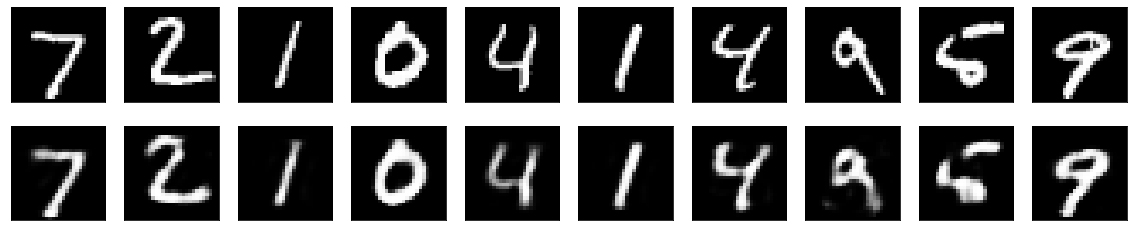

In [10]:
import matplotlib.pyplot as plt


n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(roundtrip_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

What about the compression? Let's check the sizes of the arrays.

In [11]:
encoded_imgs = autoencoder.transform(x_test)
print(f"x_test.shape[1]: {x_test.shape[1]}")
print(f"encoded_imgs.shape[1]: {encoded_imgs.shape[1]}")
cr = round((encoded_imgs.nbytes/x_test.nbytes), 2)
print(f"Compression ratio: 1/{1/cr:.0f}")

x_test.shape[1]: 784
encoded_imgs.shape[1]: 32
Compression ratio: 1/25
